# Exploring the architechture of Autoencoders

In this notebook we will see how different autoencoders are able to handle the fashion mnist dataset and our own dataset constructed with sklearn. We will use tensorflow to construct the architectures.

In [2]:
# hide if necessary
! pip install tensorflow

     ---------------------------------------- 0.0/272.8 MB ? eta -:--:--
     ---------------------------------------- 0.2/272.8 MB 4.6 MB/s eta 0:01:00
     ---------------------------------------- 0.5/272.8 MB 6.7 MB/s eta 0:00:41
     ---------------------------------------- 0.8/272.8 MB 6.6 MB/s eta 0:00:41
     ---------------------------------------- 1.1/272.8 MB 6.6 MB/s eta 0:00:42
     ---------------------------------------- 1.4/272.8 MB 6.8 MB/s eta 0:00:40
     ---------------------------------------- 1.7/272.8 MB 6.8 MB/s eta 0:00:41
     ---------------------------------------- 1.9/272.8 MB 6.9 MB/s eta 0:00:40
     ---------------------------------------- 2.2/272.8 MB 6.8 MB/s eta 0:00:40
     ---------------------------------------- 2.5/272.8 MB 6.7 MB/s eta 0:00:41
     ---------------------------------------- 2.8/272.8 MB 6.6 MB/s eta 0:00:41
     ---------------------------------------- 3.1/272.8 MB 6.8 MB/s eta 0:00:40
     ---------------------------------------- 3

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Josue\\.conda\\envs\\DataScience23\\Lib\\site-packages\\~umpy\\.libs\\libopenblas64__v0.3.21-gcc_10_3_0.dll'
Consider using the `--user` option or check the permissions.



In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [103]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import tensorflow.keras.datasets.cifar10 as c10

# Denoise Images

A useful application of autoencoders is to denoise images

In [118]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

pixel values range from 0 to 256, apart from 0 the range is 255. So dividing all the values by 255 will convert it to range from 0 to 1.

In [119]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


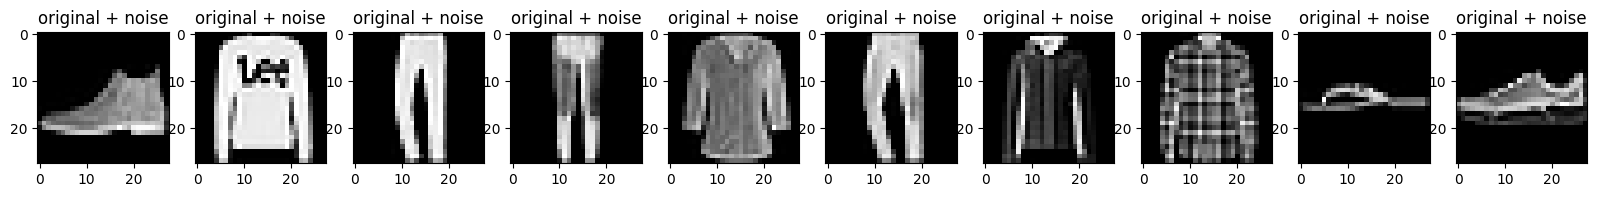

In [120]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
plt.show()

Now we will add some noise to the images

In [121]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

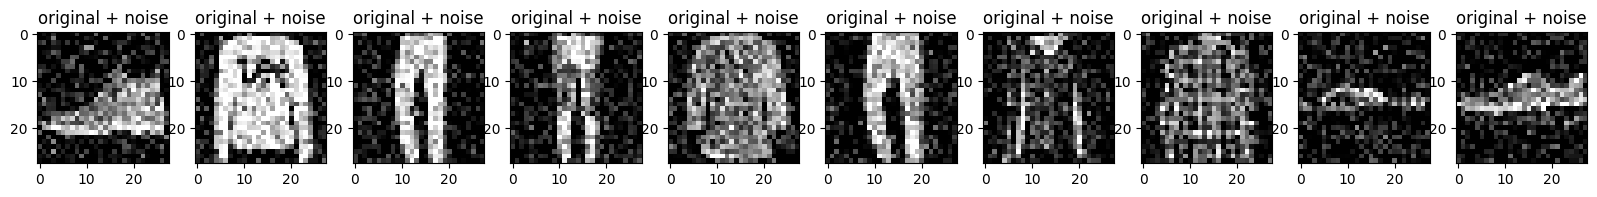

In [122]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

We will create a class and define the structure of our autoencoder.
It has two layers for both the encoder and the decoder.
Notice how the activation functions are different.

In [123]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(28, 28, 1)),
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
          layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()

Now we will compile and train our model, notice that since this is an unsupervised algorithm, the training data is also the validation data.

Adam computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients.

In [124]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [125]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0119 - val_loss: 0.0050
Epoch 2/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 3/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 4/10
1875/1875 [==============================] - 49s 26ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 5/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 6/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 7/10
1875/1875 [==============================] - 44s 23ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 8/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 9/10
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 10/10
1875/1875 [==============================] - 47s 25m

Now that we have trained our model we can test it and see the results.
We first encode the images which transforms them into a latent distribution.
Then we take this latent distribution and encode it back into an image!

In [126]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

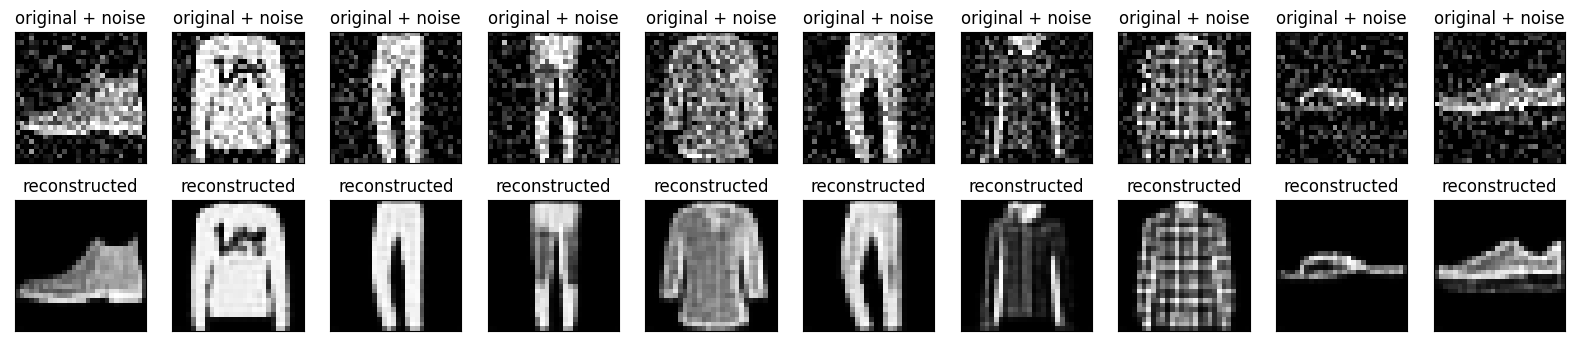

In [142]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    # display reconstruction
    
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()


Lets also save our model!

In [144]:
autoencoder.encoder.save('denoiser_encoder.h5')

In [145]:
autoencoder.decoder.save('denoiser_decoder.h5')

### Now lets reload the model!


In [148]:
autoencoder2 = Denoise()
type(autoencoder2)

__main__.Denoise

In [151]:
new_encoder = tf.keras.models.load_model('denoiser_encoder.h5')

In [152]:
autoencoder2.encoder = new_encoder

In [153]:
new_decoder = tf.keras.models.load_model('denoiser_decoder.h5')
autoencoder2.decoder = new_decoder

In [154]:
autoencoder2.encoder.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_144 (Conv2D)         (None, 14, 14, 16)        160       
                                                                 
 conv2d_145 (Conv2D)         (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


We can also input a normal image and output a normal image as well!
This concept can be really useful when trying to fix broken data that is randomly mixed with good data.

In [161]:
encoded_imgs2 = autoencoder2.encoder(x_test).numpy()
decoded_imgs2 = autoencoder2.decoder(encoded_imgs).numpy()

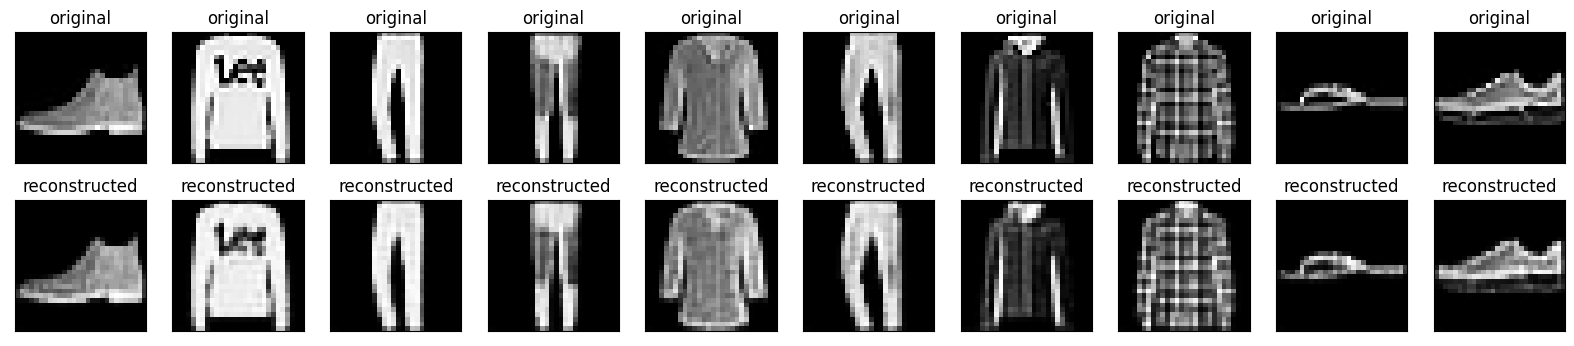

In [164]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    # display reconstruction
    
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs2[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Anomaly Detection

In [191]:
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Model and performance
import tensorflow as tf
from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

Using make_classification from the sklearn library, We created two classes with the ratio between the majority class and the minority class being 0.995:0.005. 

In [175]:
# Create an imbalanced dataset
X, y = make_classification(n_samples=100000, n_features=32, n_informative=32,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.995, 0.005],
                           class_sep=0.5, random_state=0)

Each data point has 32 features

In [176]:
print(X.shape)
print(y.shape)

(100000, 32)
(100000,)


In [178]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the majority class and {sorted(Counter(y_train).items())[1][1]} records for the minority class.")

The number of records in the training dataset is 80000
The number of records in the test dataset is 20000
The training dataset has 79200 records for the majority class and 800 records for the minority class.


Now we will create the structure of our autoencoder, this is different to our previous autoencoder.

In [179]:
# Keep only the normal data for the training dataset
X_train_normal = X_train[np.where(y_train == 0)]

In [180]:
# Input layer
input = tf.keras.layers.Input(shape=(32,)) 

# Encoder layers
encoder = tf.keras.Sequential([
  layers.Dense(16, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(4, activation='relu')])(input)

# Decoder layers
decoder = tf.keras.Sequential([
      layers.Dense(8, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="sigmoid")])(encoder)

# Create the autoencoder
anomaly_detector = tf.keras.Model(inputs=input, outputs=decoder)

MAE stands for Mean Absolute Error

In [181]:
# Compile the autoencoder
anomaly_detector.compile(optimizer='adam', loss='mae')

We are going to train the model to reconstruct normal data from normal data.

We want to do this so that it becomes really good at constructing normal data and not anomalous data.

In [239]:
# Fit the autoencoder
autoencoder_history = anomaly_detector.fit(X_train_normal, X_train_normal, 
          epochs=25, 
          batch_size=64,
          validation_data=(X_test, X_test),
          shuffle=True)

Epoch 1/25
1238/1238 [==============================] - 2s 2ms/step - loss: 2.4367 - val_loss: 2.4404
Epoch 2/25
1238/1238 [==============================] - 2s 2ms/step - loss: 2.4365 - val_loss: 2.4403
Epoch 3/25
1238/1238 [==============================] - 2s 2ms/step - loss: 2.4365 - val_loss: 2.4403
Epoch 4/25
1238/1238 [==============================] - 2s 2ms/step - loss: 2.4364 - val_loss: 2.4400
Epoch 5/25
1238/1238 [==============================] - 2s 2ms/step - loss: 2.4361 - val_loss: 2.4405
Epoch 6/25
1238/1238 [==============================] - 2s 2ms/step - loss: 2.4359 - val_loss: 2.4397
Epoch 7/25
1238/1238 [==============================] - 2s 2ms/step - loss: 2.4357 - val_loss: 2.4406
Epoch 8/25
1238/1238 [==============================] - 2s 2ms/step - loss: 2.4357 - val_loss: 2.4404
Epoch 9/25
1238/1238 [==============================] - 2s 2ms/step - loss: 2.4355 - val_loss: 2.4396
Epoch 10/25
1238/1238 [==============================] - 2s 2ms/step - loss: 2.435

Now we will visualize the loss

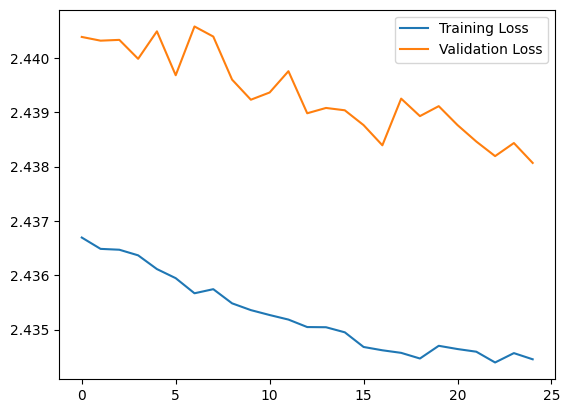

In [240]:
plt.plot(autoencoder_history.history['loss'], label='Training Loss')
plt.plot(autoencoder_history.history['val_loss'], label='Validation Loss')
plt.legend()

We can now predict anomalies we can change the loss threshold to get different results.

In [241]:
# Predict anomalies/outliers in the training dataset
prediction = anomaly_detector.predict(X_test)

625/625 [==============================] - 1s 929us/step


We will detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold.

A lower loss threshold allows us to catch more anomalies but we also falsely predict normal data as anomalies much more.

There will always be a tradeoff.

Run the code with different values for threshold_percentage to see the difference.

The prediction loss threshold for 10% of outliers is 3.03


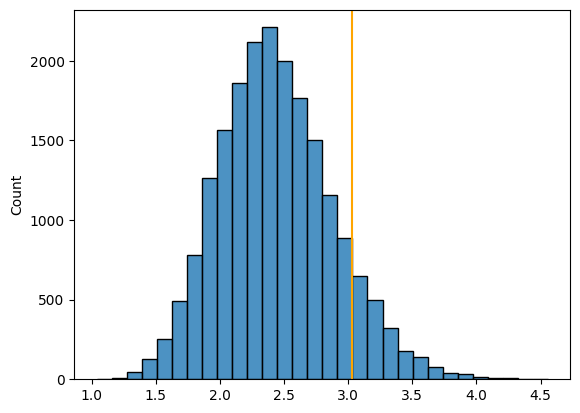

In [242]:
# Get the mean absolute error between actual and reconstruction/prediction
prediction_loss = tf.keras.losses.mae(prediction, X_test)

# Check the prediction loss threshold for % of outliers
threshold_percentage = 90
loss_threshold = np.percentile(prediction_loss, threshold_percentage)
print(f'The prediction loss threshold for {100-threshold_percentage}% of outliers is {loss_threshold:.2f}')

# Visualize the threshold
sns.histplot(prediction_loss, bins=30, alpha=0.8)
plt.axvline(x=loss_threshold, color='orange')

In [243]:
# Check the model performance at 2% threshold
threshold_prediction = [0 if i < loss_threshold else 1 for i in prediction_loss]
# # Check the prediction performance
print(classification_report(y_test, threshold_prediction))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94     19803
           1       0.01      0.08      0.01       197

    accuracy                           0.89     20000
   macro avg       0.50      0.49      0.48     20000
weighted avg       0.98      0.89      0.93     20000



In [244]:
cm = confusion_matrix(y_test, threshold_prediction)

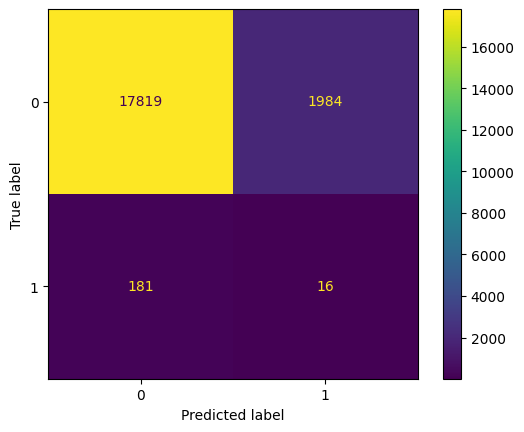

In [245]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()